## Agentic RAG

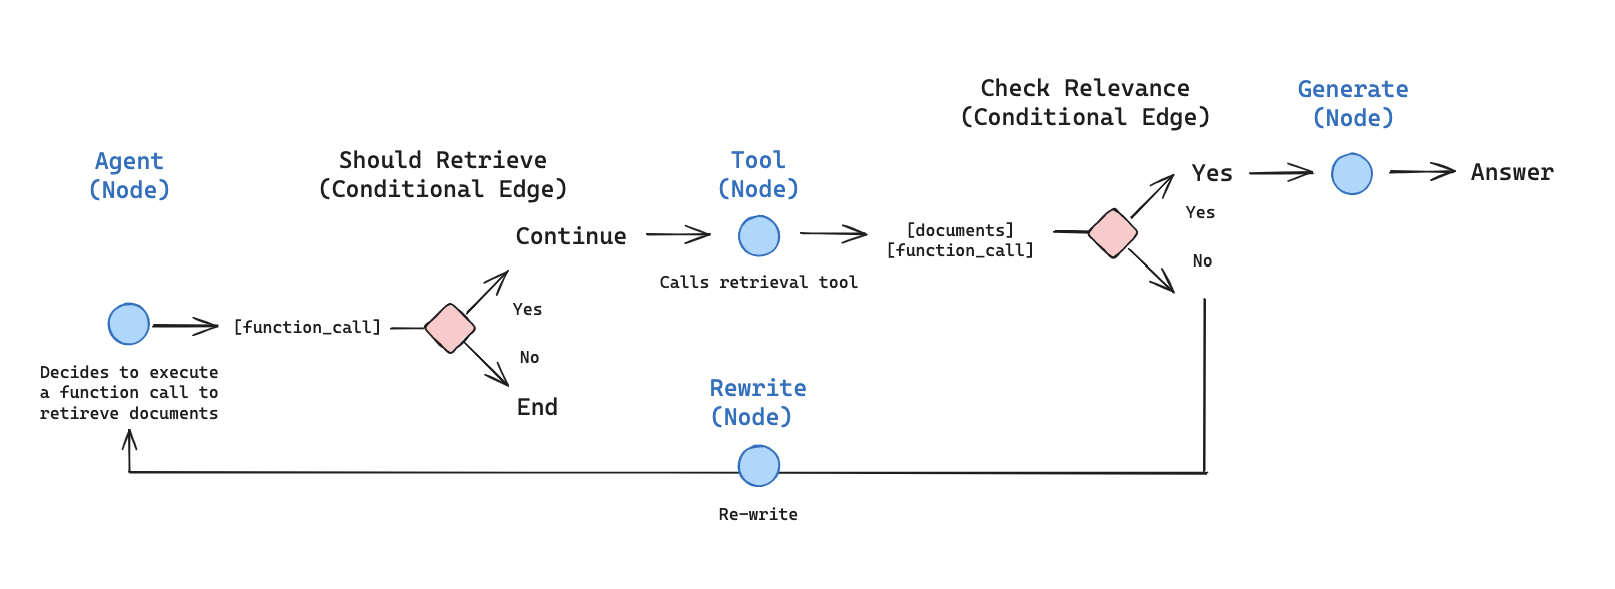

In [2]:
# Notebook setup
import warnings
warnings.filterwarnings("ignore")

import os
from dotenv import load_dotenv

# Add the project's root directory to sys.path
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
load_dotenv('../.env')

True

In [3]:
# LLM setup
from langchain_ollama import ChatOllama

model = "qwen2.5"

llm = ChatOllama(model=model, base_url="http://localhost:11434")
output = llm.invoke("Hello, how are you?")
output

AIMessage(content="Hello! I'm an AI assistant created by Alibaba Cloud, so I don't have feelings or personal experiences. But I'm here and ready to help you with any questions or tasks you might have. How can I assist you today?", additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-05-16T05:41:00.6495021Z', 'done': True, 'done_reason': 'stop', 'total_duration': 24411045200, 'load_duration': 7484959000, 'prompt_eval_count': 35, 'prompt_eval_duration': 1843038300, 'eval_count': 48, 'eval_duration': 15074952200, 'model_name': 'qwen2.5'}, id='run--48af52d6-f587-46b7-8130-5c1e281f0b90-0', usage_metadata={'input_tokens': 35, 'output_tokens': 48, 'total_tokens': 83})

## Retriever

In [4]:
# Basic Retrieval
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import FAISS 

db_name = "../00 Dataset/vector_db/"
embeddigs = OllamaEmbeddings(model="nomic-embed-text", base_url="http://localhost:11434")

vector_store_new = FAISS.load_local(db_name, embeddigs, allow_dangerous_deserialization=True)

retriever = vector_store_new.as_retriever(search_type="mmr", search_kwargs={"k": 3})


question = "What is the revenue of Facebook in 2024?"

docs = retriever.invoke(question, filter = {"company": "facebook"})
docs

[Document(id='64911e66-51e1-4006-953f-40808cd55599', metadata={'Header 2': 'CFO Outlook Commentary', 'company': 'facebook'}, page_content='## CFO Outlook Commentary  \nWe expect fourth quarter 2024 total revenue to be in the range of $45-48 billion. Our guidance assumes foreign currency is approximately neutral to year-over-year total revenue growth, based on current exchange rates.  \nWe expect full-year 2024 total expenses to be in the range of $96-98 billion, updated from our prior range of $96-99 billion. For Reality Labs, we continue to expect 2024 operating losses to increase meaningfully year-over-year due to our ongoing product development efforts and investments to further scale our ecosystem.  \nWe anticipate our full-year 2024 capital expenditures will be in the range of $38-40 billion, updated from our prior range of $37-40  billion.  We  continue  to  expect  significant  capital  expenditures  growth  in  2025.  Given  this,  along  with  the  back-end weighted nature of 

In [7]:
from query_filter import get_company_name

get_company_name("what is the revenue of amazon?")

'amazon'

In [9]:
# Step 1: Define the Custom Retriever
from typing import List
from langchain_core.retrievers import BaseRetriever
from langchain_core.documents import Document
from langchain_core.callbacks import CallbackManagerForRetrieverRun
from pydantic import Field
from langchain_community.vectorstores import FAISS
from query_filter import get_company_name


class CustomRetriever(BaseRetriever):
    """Custom retriever with query and filter support
    """
    
    vector_store: FAISS = Field(...)  # Properly declare the field using Pydantic

    def _get_relevant_documents(
        self,
        query: str,
        *,
        run_manager: CallbackManagerForRetrieverRun = None,
        **kwargs
    ) -> List[Document]:
        """Main retrieval method with filter support"""
        try:
            company = get_company_name(query)
            filter = {'company': company}
            
            print(f"\nQuery: {query}\nFilter: {filter}\n")
            return self.vector_store.similarity_search(
                query=query,
                filter=filter,
                k=5  # Number of documents to retrieve
            )
        except Exception as e:
            print(f"Retrieval error: {e}")
            return []

In [10]:
document_retriever = CustomRetriever(vector_store=vector_store_new)
document_retriever.invoke("What is the revenue of Facebook in 2024?")


Query: What is the revenue of Facebook in 2024?
Filter: {'company': 'facebook'}



[Document(id='64911e66-51e1-4006-953f-40808cd55599', metadata={'Header 2': 'CFO Outlook Commentary', 'company': 'facebook'}, page_content='## CFO Outlook Commentary  \nWe expect fourth quarter 2024 total revenue to be in the range of $45-48 billion. Our guidance assumes foreign currency is approximately neutral to year-over-year total revenue growth, based on current exchange rates.  \nWe expect full-year 2024 total expenses to be in the range of $96-98 billion, updated from our prior range of $96-99 billion. For Reality Labs, we continue to expect 2024 operating losses to increase meaningfully year-over-year due to our ongoing product development efforts and investments to further scale our ecosystem.  \nWe anticipate our full-year 2024 capital expenditures will be in the range of $38-40 billion, updated from our prior range of $37-40  billion.  We  continue  to  expect  significant  capital  expenditures  growth  in  2025.  Given  this,  along  with  the  back-end weighted nature of 

In [11]:
# 2. Retriever Tool
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    document_retriever,
    "analyst",
    "Search and return information about the financials of the company")

tools = [retriever_tool]

tools

[Tool(name='analyst', description='Search and return information about the financials of the company', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x0000024F7EE9A340>, retriever=CustomRetriever(vector_store=<langchain_community.vectorstores.faiss.FAISS object at 0x0000024F7B95A420>), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x0000024F7EE9AA20>, retriever=CustomRetriever(vector_store=<langchain_community.vectorstores.faiss.FAISS object at 0x0000024F7B95A420>), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'))]

In [12]:
retriever_tool.invoke("What is the revenue of Facebook in 2024?")


Query: What is the revenue of Facebook in 2024?
Filter: {'company': 'facebook'}



'## CFO Outlook Commentary  \nWe expect fourth quarter 2024 total revenue to be in the range of $45-48 billion. Our guidance assumes foreign currency is approximately neutral to year-over-year total revenue growth, based on current exchange rates.  \nWe expect full-year 2024 total expenses to be in the range of $96-98 billion, updated from our prior range of $96-99 billion. For Reality Labs, we continue to expect 2024 operating losses to increase meaningfully year-over-year due to our ongoing product development efforts and investments to further scale our ecosystem.  \nWe anticipate our full-year 2024 capital expenditures will be in the range of $38-40 billion, updated from our prior range of $37-40  billion.  We  continue  to  expect  significant  capital  expenditures  growth  in  2025.  Given  this,  along  with  the  back-end weighted nature of our 2024 capital expenditures, we expect a significant acceleration in infrastructure expense growth next year as we recognize higher grow

## Agent

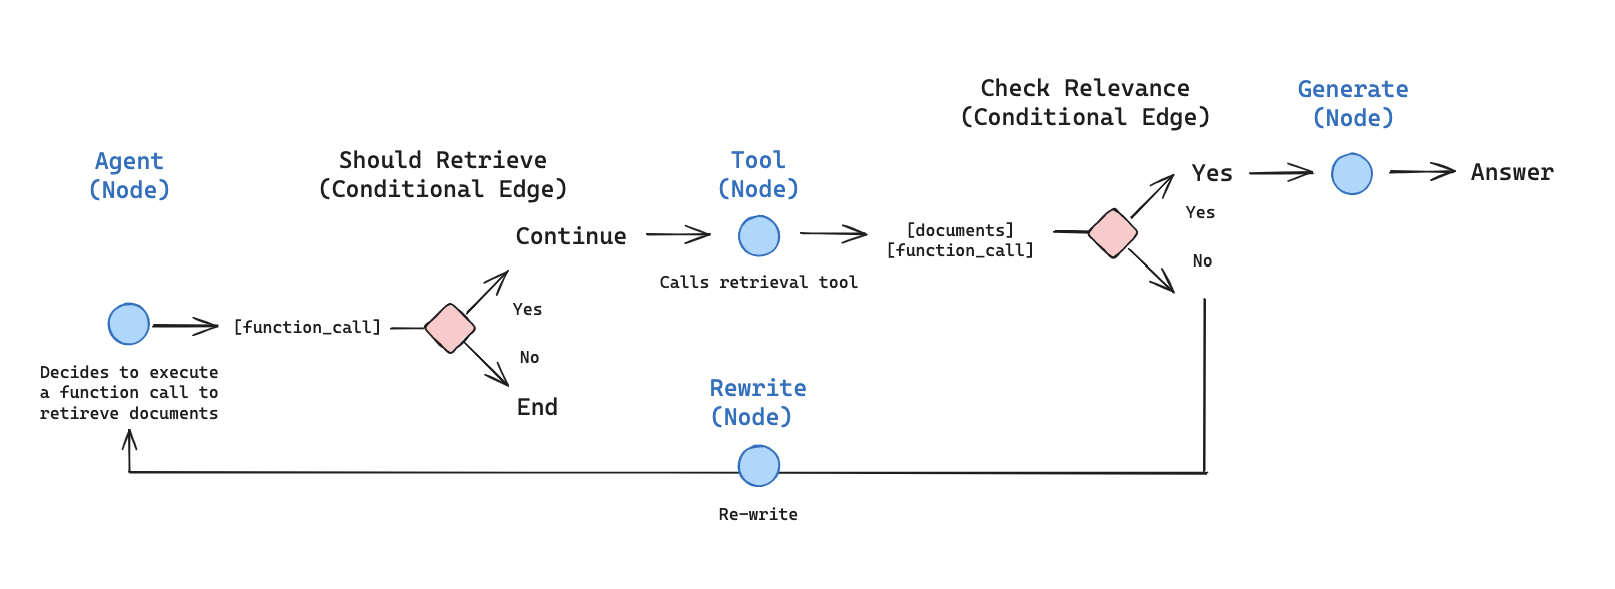

We can lay out an agentic RAG graph like this:

- The state is a set of messages
- Each node will update (append to) state
- Conditional edges decide which node to visit next

In [14]:
# LangGraph State Setup
from typing import Annotated, Sequence, TypedDict 
from langchain_core.messages import BaseMessage
from langchain_core.messages import HumanMessage

from langgraph.prebuilt import tools_condition
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

### Agent Node

In [15]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]

    llm_with_tools = llm.bind_tools(tools, tool_choice="required")
    response = llm_with_tools.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [16]:
state = {"messages": [HumanMessage(content="What is the earning of Facebook?")]}
agent(state)

---CALL AGENT---


{'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-05-16T07:08:32.5299619Z', 'done': True, 'done_reason': 'stop', 'total_duration': 13126318500, 'load_duration': 7480479500, 'prompt_eval_count': 172, 'prompt_eval_duration': 1485129900, 'eval_count': 21, 'eval_duration': 4155944200, 'model_name': 'qwen2.5'}, id='run--6ca6a5b9-7ece-4574-a710-73b6d0134ab9-0', tool_calls=[{'name': 'analyst', 'args': {'query': 'Facebook earnings'}, 'id': 'c14fba36-fe57-403f-902e-b2a4f51e2848', 'type': 'tool_call'}], usage_metadata={'input_tokens': 172, 'output_tokens': 21, 'total_tokens': 193})]}

### Graph
- Start with an agent, call_model
- Agent make a decision to call a function
- If so, then action to call tool (retriever)
- Then call agent with the tool output added to messages (state)

In [17]:
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode
from graph_nodes import grade_documents, rewrite, generate

In [18]:
# Graph Building
graph_builder = StateGraph(State)

graph_builder.add_node("agent", agent)
retriever = ToolNode([retriever_tool])
graph_builder.add_node("retriever", retriever)
graph_builder.add_node("rewrite", rewrite)

graph_builder.add_node("generate", generate)


graph_builder.add_edge(START, "agent")

graph_builder.add_conditional_edges( 
    "agent",

    tools_condition,
    {
        "tools": "retriever",
        END: END
    }
)

graph_builder.add_conditional_edges(
    "retriever",
    grade_documents
)

graph_builder.add_edge("generate", END)
graph_builder.add_edge("rewrite", "agent")

graph = graph_builder.compile()



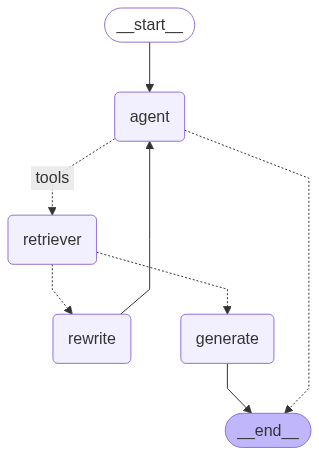

In [19]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Agent in Action

In [23]:
from pprint import pprint

query = {"messages": [HumanMessage("Tell me about the earning of Google?")]}
# graph.invoke(query)

for output in graph.stream(query):
    for key, value in output.items():
        pprint(f"Output from node '{key}':")
        pprint("----")
        pprint(value, indent=4, width=120)

    pprint("\n------\n")


---CALL AGENT---
"Output from node 'agent':"
'----'
{   'messages': [   AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-05-16T07:27:09.7175822Z', 'done': True, 'done_reason': 'stop', 'total_duration': 7776389400, 'load_duration': 106051100, 'prompt_eval_count': 173, 'prompt_eval_duration': 1310870900, 'eval_count': 21, 'eval_duration': 6342930600, 'model_name': 'qwen2.5'}, id='run--21b04f19-b771-45c8-98a5-7468295f6d37-0', tool_calls=[{'name': 'analyst', 'args': {'query': 'Google earnings'}, 'id': '5bbf6cb7-f5d0-44f2-9cac-2234da03fdac', 'type': 'tool_call'}], usage_metadata={'input_tokens': 173, 'output_tokens': 21, 'total_tokens': 194})]}
'\n------\n'

Query: Google earnings
Filter: {'company': 'google'}

---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
"Output from node 'retriever':"
'----'
{   'messages': [   ToolMessage(content='## Google advertising revenues\n\n## Google Services  \nGoogle Services operating  income  increas